## 1. Introducción y Objetivos del Proyecto

He seleccionado el dataset de Rossmann Store Sales porque se ajusta a los criterios de evaluación de la práctica al pertenecer al dominio del retail y poder implementar un modelo de regresión tal como se nos recomienda en la guía aparte de poder aplicar un Pipeline parecido al ejercicio opcional del DataCamp.

Como reto al implementar el modelo de regresión, se va a predecir la variable `Sales` basándonos en datos históricos de las tiendas, información sobre promociones, competidores y festivos usando Spark.

El notebook estara dividido en los siguientes apartados:
1.  **Carga y Limpieza de Datos:** Inferencia de esquemas y tratamiento de nulos.
2.  **Análisis Exploratorio de Datos (EDA):** Visualización de patrones de ventas.
3.  **Ingeniería de Características:** Transformación de fechas y codificación de variables categóricas (`OneHotEncoding`).
4.  **Modelado:** Entrenamiento de modelos de Regresión (*Random Forest* y *Gradient-Boosted Trees*).
5.  **Evaluación:** Comparativa de métricas (RMSE, MAE) y análisis de importancia de variables.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofmonth, weekofyear, to_date, when, count, isnan
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
# he tenido muchos problemas con memoria para entrenar el modelo, asi que he decicido ampliarlo al maximo que me podia permitir
spark = SparkSession.builder \
    .appName("Ejercicio2Modelo") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "2g") \
    .getOrCreate()

## 2. Carga y Exploración Inicial de Datos

Cargamos los datasets `train.csv` (ventas históricas) y `store.csv` (información de las tiendas). Usamos `inferSchema=True` para detectar automáticamente los tipos de datos, aunque verificaremos que sean correctos posteriormente.

In [3]:
train_df = spark.read.csv("work/train.csv", header=True, inferSchema=True)
store_df = spark.read.csv("work/store.csv", header=True, inferSchema=True)
train_df.cache()

print("Dimensiones Train")
print(f"{train_df.count()} filas, {len(train_df.columns)} columnas")
print("Dimensiones Store")
print(f"{store_df.count()} filas, {len(store_df.columns)} columnas")

train_df.show(5)

Dimensiones Train
1017209 filas, 9 columnas
Dimensiones Store
1115 filas, 10 columnas
+-----+---------+----------+-----+---------+----+-----+------------+-------------+
|Store|DayOfWeek|      Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|
+-----+---------+----------+-----+---------+----+-----+------------+-------------+
|    1|        5|2015-07-31| 5263|      555|   1|    1|           0|            1|
|    2|        5|2015-07-31| 6064|      625|   1|    1|           0|            1|
|    3|        5|2015-07-31| 8314|      821|   1|    1|           0|            1|
|    4|        5|2015-07-31|13995|     1498|   1|    1|           0|            1|
|    5|        5|2015-07-31| 4822|      559|   1|    1|           0|            1|
+-----+---------+----------+-----+---------+----+-----+------------+-------------+
only showing top 5 rows



### 2.1 Limpieza y Unión de Datos

Antes de modelar, realizamos una limpieza esencial:
Eliminamos registros donde las tiendas están cerradas (`Open == 0`) o no hubo ventas (`Sales == 0`), ya que no aportan información relevante para predecir el volumen de ventas futuras.

Unimos amblas tablas usando los datos de ventas y cruzándolos con la información de las tiendas (`store.csv`).

Visualizaremos los nulos por columnas y decidiremos una estrategia por cada uno.

In [4]:
# filtramos por tiendas abiertas y con ventas
train_cleaned = train_df.filter((col("Open") == 1) & (col("Sales") > 0))

# unimos ambas tablas con left
data = train_cleaned.join(store_df, "Store", "left")

# vemos los nulos por campo
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).toPandas().T


,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
StoreType,0


Para el tratamiento de nulos, hemos detectado 5 columnas con una gran cantidad de nulos, seguiremos una estrategia diferente para cada una:
- CompetitionDistance: Asumimos que si no hay dato es por que la competencia esta tan lejos que no afecta a la tienda, por lo que usaremos un valor muy alto para que el modelo entienda que la competencia es irrelevante.
- CompetitionOpenSinceMonth: Si no hay fecha de apertura de la competencía seguramente se deba a que CompetitionDistance también es nulo, usaremos 0 para que el modelo trate estos datos como una categoria aparte
- Promo2SinceWeek/Year: Significa que la tienda no participa en la Promo2, por lo que el valor sera 0 para que el modelo entienda que no participa en la promoción
- PromoInterval: Se trata de una variable categórica que el nulo confirma que no hay intervalo de promoción, rellenaremos con "None" para que mas tarde en el StringIndexer se pueda procesar correctamente.

In [5]:
distancia_max = data.agg({"CompetitionDistance": "max"}).collect()[0][0]
fill_values = {
    "CompetitionDistance": distancia_max * 2, # es posible que necesite aumentarlo si el modelo no entiende que es irrelevante
    "CompetitionOpenSinceMonth": 0,
    "CompetitionOpenSinceYear": 0,
    "Promo2SinceWeek": 0,
    "Promo2SinceYear": 0,
    "PromoInterval": "None"
}

data = data.fillna(fill_values)

print(f"Registros tras limpieza: {data.count()}")
#observamos si hemos procesado bien los nulos
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).toPandas().T

Registros tras limpieza: 844338


,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
StoreType,0


## 3. Análisis Exploratorio de Datos (EDA)

Para entender mejor la naturaleza de nuestras ventas, convertiremos una muestda a **Pandas** para visualizarla con Seaborn siguiendo los ejemplos del curso de DataCamp.

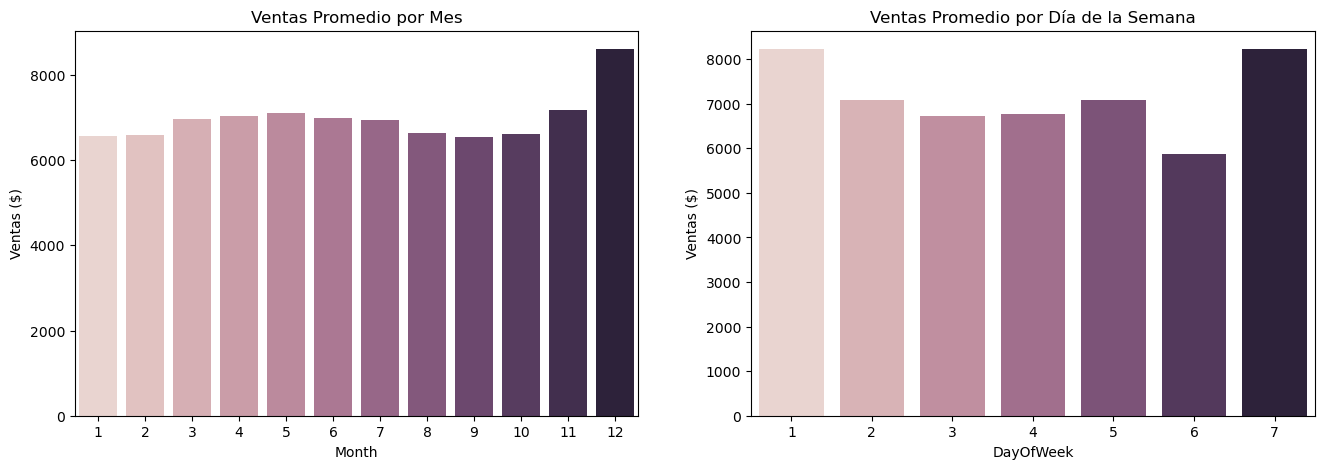

In [6]:
# ventas por mes
sales_per_month = data.withColumn("Month", month("Date")) \
                      .groupBy("Month") \
                      .avg("Sales") \
                      .orderBy("Month") \
                      .toPandas()

# ventas por dia
sales_per_day = data.groupBy("DayOfWeek") \
                    .avg("Sales") \
                    .orderBy("DayOfWeek") \
                    .toPandas()

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.barplot(x="Month", y="avg(Sales)", data=sales_per_month, ax=ax[0], hue="Month", legend=False)
ax[0].set_title("Ventas Promedio por Mes")
ax[0].set_ylabel("Ventas ($)")

sns.barplot(x="DayOfWeek", y="avg(Sales)", data=sales_per_day, ax=ax[1], hue="DayOfWeek", legend=False)
ax[1].set_title("Ventas Promedio por Día de la Semana")
ax[1].set_ylabel("Ventas ($)")

plt.show()

## 3.1 Conclusiones del EDA
- Podemos observar un incremento notable en las ventas en los meses de noviembre y diciembre, seguramente debido a la campaña navideña
- En el ciclo semanal existe una clara fluctuación dependiendo del día, con picos en los lunes y domingos lo que nos confirma que el factor temporal es un predictor importante
- Dado que la variabilidad es claramente no lineal, los modelos elegidos para el entrenamiento posterior basados en árboles deberían obtener buenos resultados

## 4. Ingeniería de Características (Feature Engineering)

Para que los algoritmos de Machine Learning procesen correctamente la información, realizamos dos transformaciones clave:

1.  **Descomposición de Fechas:** Extraemos Año, Mes, Día y Semana de la columna `Date`.
2.  **Codificación de Variables Categóricas:** Usamos `StringIndexer` seguido de `OneHotEncoder`.
3.  **Codificación Especial:** Para la columna `store` solo se le aplicara `StringIndexer` debido a la alta dimensionalidad de esta misma que aumentaria demasiado la complejidad del modelo

In [ ]:
# formateamos correctamente con la fecha
data_fe = data.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd")) \
              .withColumn("Year", year(col("Date"))) \
              .withColumn("Month", month(col("Date"))) \
              .withColumn("Day", dayofmonth(col("Date"))) \
              .withColumn("Week", weekofyear(col("Date")))

stages = []

# separamos columnas para su tratamiento
categorical_cols = ["StoreType", "Assortment", "StateHoliday"]
numeric_cols = ["CompetitionDistance", "Promo", "Year", "Month", "Day", "Week", "DayOfWeek", 
                "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2"]

# aplicamos StringIndexer solo
store_indexer = StringIndexer(inputCol="Store", outputCol="Store_idx", handleInvalid="keep")
stages += [store_indexer]

for cat_col in categorical_cols:
    # aplicamos StringIndexer y OneHotEncoder a las categoricas
    indexer = StringIndexer(inputCol=cat_col, outputCol=cat_col + "_idx", handleInvalid="keep")
    encoder = OneHotEncoder(inputCols=[cat_col + "_idx"], outputCols=[cat_col + "_vec"])
    stages += [indexer, encoder]

# creamos el vector para tener las features listas
assembler_inputs = ["Store_idx"] + [c + "_vec" for c in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features", handleInvalid="keep")
stages += [assembler]

# ejecutamos el pipeline
pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(data_fe)
final_data = pipeline_model.transform(data_fe)

# dejamos solamente los datos importantes
final_data = final_data.select("features", col("Sales").alias("label"), "Date")

## 5. División del Conjunto de Datos (Train / Test)

Dado que estamos ante una **serie temporal**, no podemos hacer una división aleatoria (random split). Entrenar con datos del futuro para predecir el pasado sería un error metodológico grave (*data leakage*).

**Estrategia:**
* **Train:** Datos anteriores al 15 de junio de 2015.
* **Test:** Datos posteriores al 15 de junio de 2015 (últimas 6 semanas del dataset).

In [10]:
split_date = "2015-06-15"

train_data = final_data.filter(col("Date") <= split_date)
test_data = final_data.filter(col("Date") > split_date)

print(f"Registros de Entrenamiento: {train_data.count()}")
print(f"Registros de Test: {test_data.count()}")

Registros de Entrenamiento: 799600
Registros de Test: 44738


## 6. Construcción y Comparativa de Modelos

Vamos a entrenar y comparar dos algoritmos robustos para regresión:

1.  **Random Forest Regressor:** Un modelo de ensamble que reduce el riesgo de sobreajuste promediando múltiples árboles de decisión. Es robusto y paralelizable.
2.  **Gradient-Boosted Trees (GBT):** Construye árboles secuencialmente para corregir los errores de los anteriores. Suele ofrecer mayor precisión en competiciones, aunque es más lento de entrenar.

*Nota: Hemos configurado hiperparámetros mods=50`) para equilibrar tiempo de cómputo y prucativo.*

In [12]:
print("Entrenando Random Forest")
rf = RandomForestRegressor(
    featuresCol="features", 
    labelCol="label", 
    numTrees=100, 
    maxDepth=12,
    maxBins=1116
)
rf_model = rf.fit(train_data)

Entrenando Random Forest


In [14]:
print("Entrenando GBT Regressor")
gbt = GBTRegressor(
    featuresCol="features", 
    labelCol="label", 
    maxIter=50, 
    maxDepth=7, 
    maxBins=1116
)
gbt_model = gbt.fit(train_data)

Entrenando GBT Regressor


## 7. Evaluación y Métricas

Para evaluar el desempeño, calcularemos:
* **RMSE (Root Mean Squared Error):** Nuestra métrica principal, penaliza los errores grandes.
* **MAE (Mean Absolute Error):** Para tener una referencia lineal del error en euros.
* **$R^2$ (Coeficiente de Determinación):** Indica qué porcentaje de la variabilidad de las ventas es explicado por el modelo($).

In [17]:
# Predicciones
preds_rf = rf_model.transform(test_data)
preds_gbt = gbt_model.transform(test_data)

# Evaluadores
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

# Cálculo de métricas
rmse_rf = evaluator_rmse.evaluate(preds_rf)
mae_rf = evaluator_mae.evaluate(preds_rf)
r2_rf = evaluator_r2.evaluate(preds_rf)

rmse_gbt = evaluator_rmse.evaluate(preds_gbt)
mae_gbt = evaluator_mae.evaluate(preds_gbt)
r2_gbt = evaluator_r2.evaluate(preds_gbt)

print(f"Random Forest: RMSE = {rmse_rf:.2f} | MAE = {mae_rf:.2f} | R2 = {r2_rf:.4f}")
print(f"GBT Regressor: RMSE = {rmse_gbt:.2f} | MAE = {mae_gbt:.2f} | R2 = {r2_gbt:.4f}")

Random Forest: RMSE = 1057.03 | MAE = 740.24 | R2 = 0.8786
GBT Regressor: RMSE = 923.32 | MAE = 632.13 | R2 = 0.9074


## 8. Conclusiones y Valoración Personal

### Análisis de Resultados
Tras ejecutar ambos modelos sobre el conjunto de test (últimas 6 semanas de ventas), los resultados han sido concluyentes:

* Random Forest: RMSE: 1057.03 | MAE: 740.24 | $R^2$: 0.8786
* GBT Regressor: RMSE: 923.32 | MAE: 632.13 | $R^2$: 0.9074

El modelo GBT (Gradient-Boosted Trees) se posiciona como la solución óptima para este problema. Lograr un coeficiente de determinación ($R^2$) de 0.9074 es un resultado sobresaliente, ya que significa que el modelo es capaz de explicar más del 90% de la variabilidad de las ventas de Rossmann.

Con un MAE de ~632€, el modelo demuestra una gran precisión, considerando que las ventas diarias suelen oscilar en rangos mucho mayores. La superioridad del GBT frente al Random Forest (reduciendo el RMSE en más de 130 puntos) confirma que el aprendizaje secuencial del boosting es mucho más efectivo para capturar las tendencias no lineales y la estacionalidad compleja presentes en los datos de retail.

### Valoración del Proyecto
Este ejercicio ha permitido afianzar los conceptos de MLlib y Pipelines. 
* **Punto fuerte:** La implementación del Pipeline con `OneHotEncoder` y la división temporal lógica de los datos.
* **Dificultad:** El ajuste de los tipos de datos y la gestión de memoria al trabajar en local.
* **Mejora futura:** Para un entorno de producción, añadiría una etapa de **Hyperparameter Tuning** (usando `CrossValidator` con un `ParamGrid`), aunque en esta práctica se ha omitido por el alto coste computacional que supondría en una máquina local.